## Finetuning FastPitch

In this tutorial, we will finetune a single speaker FastPitch (with alignment) model on 5 mins of a new speaker's data. We will finetune the model parameters only on the new speaker's text and speech pairs (though see the section at the end to learn more about mixing speaker data).

We will download the training data, then generate and run a training command to finetune Fastpitch on 5 mins of data, and synthesize the audio from the trained checkpoint.

A final section will describe approaches to improve audio quality past this notebook.

In [1]:
import os
import json
from pathlib import Path

import wandb

import torch
import pandas as pd
import IPython.display as ipd
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

Let's also download the pretrained checkpoint that we want to finetune from. NeMo will save checkpoints to `~/.cache`, so let's move that to our current directory. 

*Note: please, check that `home_path` refers to your home folder. Otherwise, change it manually.*

In [2]:
SPEAKER_ID = 9017
MODEL_NAME = "tts_en_fastpitch"

WANDB_PROJECT = "tts-workshop"
WANDB_ENTITY = "capecape" # replace with your wandb username or team

Let's download the pretrained model

In [3]:
from nemo.collections.tts.models import FastPitchModel
FastPitchModel.from_pretrained(MODEL_NAME);

[NeMo W 2022-12-07 15:55:20 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2022-12-07 15:55:20 experimental:27] Module <class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-12-07 15:55:20 experimental:27] Module <class 'nemo.collections.tts.models.radtts.RadTTSModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.


[NeMo I 2022-12-07 15:55:20 cloud:56] Found existing object /home/tcapelle/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_en_fastpitch_align/b7d086a07b5126c12d5077d9a641a38c/tts_en_fastpitch_align.nemo.
[NeMo I 2022-12-07 15:55:20 cloud:62] Re-using file from: /home/tcapelle/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_en_fastpitch_align/b7d086a07b5126c12d5077d9a641a38c/tts_en_fastpitch_align.nemo
[NeMo I 2022-12-07 15:55:20 common:912] Instantiating model from pre-trained checkpoint
[NeMo I 2022-12-07 15:55:23 tokenize_and_classify:87] Creating ClassifyFst grammars.


[NeMo W 2022-12-07 15:55:54 experimental:27] Module <class 'nemo_text_processing.g2p.modules.IPAG2P'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-12-07 15:55:54 modules:95] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2022-12-07 15:55:54 modelPT:142] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /ws/LJSpeech/nvidia_ljspeech_train_clean_ngc.json
      sample_rate: 22050
      sup_data_path: /raid/LJSpeech/supplementary
      sup_data_types:
      - align_prior_m

[NeMo I 2022-12-07 15:55:55 features:267] PADDING: 1
[NeMo I 2022-12-07 15:55:57 save_restore_connector:243] Model FastPitchModel was successfully restored from /home/tcapelle/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_en_fastpitch_align/b7d086a07b5126c12d5077d9a641a38c/tts_en_fastpitch_align.nemo.


We will copy the model to our current working dir for simplicity

In [4]:
for nemo_file in (Path.home()/".cache/torch/NeMo/").glob(f"**/{MODEL_NAME}_align.nemo"):
    print(f"Copying {nemo_file} to ./{nemo_file.name}")
    Path(f"./{nemo_file.name}").write_bytes(nemo_file.read_bytes())

Copying /home/tcapelle/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_en_fastpitch_align/b7d086a07b5126c12d5077d9a641a38c/tts_en_fastpitch_align.nemo to ./tts_en_fastpitch_align.nemo
Copying /home/tcapelle/.cache/torch/NeMo/NeMo_1.12.0/tts_en_fastpitch_align/26d7e09971f1d611e24df90c7a9d9b38/tts_en_fastpitch_align.nemo to ./tts_en_fastpitch_align.nemo


## Train Time!

We can now train our model with the following command:

**NOTE: This will take about 30 minutes on colab's T4 GPUs.**

### Using Hydra in Jupyter...

In [5]:
import pytorch_lightning as pl

from nemo.collections.common.callbacks import LogEpochTimeCallback
from nemo.utils.exp_manager import exp_manager

from hydra import compose, initialize

In [6]:
with initialize(config_path="./conf"):
    cfg = compose(config_name="fastpitch_align_v1.05.yaml")
    
    # or use the nice hydra API 🤣
    # cfg = compose(config_name="fastpitch_align_v1.05.yaml",
    #               overrides=['train_dataset=9017_manifest_train_local.json',
    #                          'validation_datasets=9017_manifest_valid_local.json',
    #                          '+exp_manager.create_wandb_logger=True',
    #                          f'+exp_manager.wandb_logger_kwargs=\{project:{WANDB_PROJECT}, job_type:training, log_model:True\}',
    #                          'model.pitch_mean=152.3',
    #                          'model.pitch_std=64.0',
    #                          'model.pitch_fmin=30',
    #                          'model.pitch_fmax=512',
    #                          'trainer.max_steps=10',
    #                         ]
    #              )

In [8]:
# datasets
cfg.train_dataset = "9017_manifest_train_local.json"
cfg.validation_datasets = "9017_manifest_valid_local.json"

# speaker params
cfg.model.pitch_mean = 152.3
cfg.model.pitch_std = 64.0
cfg.model.pitch_fmin = 30
cfg.model.pitch_fmax = 512

#wandb
cfg.exp_manager.create_wandb_logger = True
cfg.exp_manager.wandb_logger_kwargs = {"project":WANDB_PROJECT, "job_type":"training", "log_model":True}

# iterate fast
cfg.trainer.max_steps = 10

In [9]:
trainer = pl.Trainer(**cfg.trainer, enable_progress_bar=False)
exp_manager(trainer, cfg.get("exp_manager", None))

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[NeMo I 2022-12-07 15:56:25 exp_manager:343] Experiments will be logged at exp_dir/FastPitch/2022-12-07_15-56-25


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: capecape. Use `wandb login --relogin` to force relogin


[NeMo I 2022-12-07 15:56:31 exp_manager:733] WandBLogger has been set up


[NeMo W 2022-12-07 15:56:31 exp_manager:988] The checkpoint callback was told to monitor a validation value and trainer's max_steps was set to 10. Please ensure that max_steps will run for at least 10 epochs to ensure that checkpointing will not error out.


PosixPath('exp_dir/FastPitch/2022-12-07_15-56-25')

We can create model lineage with the split

In [10]:
wandb_artifact=f'{WANDB_ENTITY}/{WANDB_PROJECT}/9017_5_split:v0'
wandb.use_artifact(wandb_artifact)

<Artifact QXJ0aWZhY3Q6Mjk0NjExNzQw>

Configure the logging and load the pretrained model

In [11]:
model = FastPitchModel(cfg=cfg.model, trainer=trainer)
model.maybe_init_from_pretrained_checkpoint(cfg=cfg)
lr_logger = pl.callbacks.LearningRateMonitor()
epoch_time_logger = LogEpochTimeCallback()
trainer.callbacks.extend([lr_logger, epoch_time_logger])

[NeMo I 2022-12-07 15:56:34 tokenize_and_classify:87] Creating ClassifyFst grammars.


[NeMo W 2022-12-07 15:57:06 modules:95] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.


[NeMo I 2022-12-07 15:57:06 data:217] Loading dataset from 9017_manifest_train_local.json.


76it [00:00, 117064.67it/s]

[NeMo I 2022-12-07 15:57:06 data:254] Loaded dataset with 76 files.
[NeMo I 2022-12-07 15:57:06 data:256] Dataset contains 0.08 hours.
[NeMo I 2022-12-07 15:57:06 data:358] Pruned 0 files. Final dataset contains 76 files
[NeMo I 2022-12-07 15:57:06 data:360] Pruned 0.00 hours. Final dataset contains 0.08 hours.
[NeMo I 2022-12-07 15:57:06 data:217] Loading dataset from 9017_manifest_valid_local.json.



2it [00:00, 3826.92it/s]

[NeMo I 2022-12-07 15:57:06 data:254] Loaded dataset with 2 files.
[NeMo I 2022-12-07 15:57:06 data:256] Dataset contains 0.00 hours.
[NeMo I 2022-12-07 15:57:06 data:358] Pruned 0 files. Final dataset contains 2 files
[NeMo I 2022-12-07 15:57:06 data:360] Pruned 0.00 hours. Final dataset contains 0.00 hours.
[NeMo I 2022-12-07 15:57:06 features:267] PADDING: 1


[NeMo I 2022-12-07 15:57:10 tokenize_and_classify:87] Creating ClassifyFst grammars.


[NeMo W 2022-12-07 15:57:44 modules:95] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2022-12-07 15:57:44 modelPT:142] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /ws/LJSpeech/nvidia_ljspeech_train_clean_ngc.json
      sample_rate: 22050
      sup_data_path: /raid/LJSpeech/supplementary
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null
      min_du

[NeMo I 2022-12-07 15:57:44 features:267] PADDING: 1
[NeMo I 2022-12-07 15:57:44 save_restore_connector:243] Model FastPitchModel was successfully restored from /home/tcapelle/wandb/nvidia-workshop/tts_en_fastpitch_align.nemo.
[NeMo I 2022-12-07 15:57:44 modelPT:1067] Model checkpoint restored from nemo file with path : `./tts_en_fastpitch_align.nemo`


time to train the model

In [12]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2022-12-07 15:57:44 modelPT:602] Optimizer config = Adam (
    Parameter Group 0
        amsgrad: False
        betas: [0.9, 0.999]
        capturable: False
        differentiable: False
        eps: 1e-08
        foreach: None
        fused: False
        lr: 0.0002
        maximize: False
        weight_decay: 1e-06
    )
[NeMo I 2022-12-07 15:57:44 lr_scheduler:772] Scheduler not initialized as no `sched` config supplied to setup_optimizer()



  | Name                | Type                              | Params
--------------------------------------------------------------------------
0 | mel_loss_fn         | MelLoss                           | 0     
1 | pitch_loss_fn       | PitchLoss                         | 0     
2 | duration_loss_fn    | DurationLoss                      | 0     
3 | energy_loss_fn      | EnergyLoss                        | 0     
4 | aligner             | AlignmentEncoder                  | 1.0 M 
5 | forward_sum_loss_fn | ForwardSumLoss                    | 0     
6 | bin_loss_fn         | BinLoss                           | 0     
7 | preprocessor        | AudioToMelSpectrogramPreprocessor | 0     
8 | fastpitch           | FastPitchModule                   | 45.8 M
--------------------------------------------------------------------------
45.8 M    Trainable params
0         Non-trainable params
45.8 M    Total params
91.518    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_s

In [13]:
wandb.finish()

epoch,▁
epoch_time,█▁
lr-Adam,▁▁▁
t_bin_loss,▁
t_ctc_loss,▁
t_dur_loss,▁
t_loss,▁
t_mel_loss,▁
t_pitch_loss,▁
train_backward_timing,▁
train_step_timing,▁


### Running as a python program on a shell

> I recommend to run this command on a terminal instead of on the notebooks itself

```bash
python fastpitch_finetune.py --config-name=fastpitch_align_v1.05.yaml \
  train_dataset=9017_manifest_train_local.json \
  validation_datasets=9017_manifest_valid_local.json \
  exp_manager.exp_dir=./fastpitch_finetune \
  +exp_manager.create_wandb_logger=True \
  +wandb_artifact='capecape/tts-workshop/9017_5_split:v0' \
  +exp_manager.wandb_logger_kwargs='{project:tts-workshop, job_type:training, log_model:True}' \
  +init_from_nemo_model=./tts_en_fastpitch_align.nemo \
  model.pitch_mean=152.3 model.pitch_std=64.0 \
  model.pitch_fmin=30 model.pitch_fmax=512 \
  trainer.max_steps=10 \
```


Let's take a closer look at the training command:

* `--config-name=fastpitch_align_v1.05.yaml`
  * We first tell the script what config file to use.

* `train_dataset=./6097_manifest_train_dur_5_mins_local.json 
  validation_datasets=./6097_manifest_dev_ns_all_local.json 
  sup_data_path=./fastpitch_sup_data`
  * We tell the script what manifest files to train and eval on, as well as where supplementary data is located (or will be calculated and saved during training if not provided).
  
* `phoneme_dict_path=tts_dataset_files/cmudict-0.7b_nv22.10 
heteronyms_path=tts_dataset_files/heteronyms-052722
whitelist_path=tts_dataset_files/lj_speech.tsv 
`
  * We tell the script where `phoneme_dict_path`, `heteronyms-052722` and `whitelist_path` are located. These are the additional files we downloaded earlier, and are used in preprocessing the data.
  
* `exp_manager.exp_dir=./ljspeech_to_6097_no_mixing_5_mins`
  * Where we want to save our log files, tensorboard file, checkpoints, and more.

* `+init_from_nemo_model=./tts_en_fastpitch_align.nemo`
  * We tell the script what checkpoint to finetune from.

* `+trainer.max_steps=1000 ~trainer.max_epochs trainer.check_val_every_n_epoch=25`
  * For this experiment, we tell the script to train for 1000 training steps/iterations rather than specifying a number of epochs to run. Since the config file specifies `max_epochs` instead, we need to remove that using `~trainer.max_epochs`.

* `model.train_ds.dataloader_params.batch_size=24 model.validation_ds.dataloader_params.batch_size=24`
  * Set batch sizes for the training and validation data loaders.

* `model.n_speakers=1`
  * The number of speakers in the data. There is only 1 for now, but we will revisit this parameter later in the notebook.

* `model.pitch_mean=152.3 model.pitch_std=64.0 model.pitch_fmin=30 model.pitch_fmax=512`
  * For the new speaker, we need to define new pitch hyperparameters for better audio quality.
  * These parameters work for speaker 9017 from the Hi-Fi TTS dataset.
  * fmin and fmax are hyperparameters to librosa's pyin function. We recommend tweaking these per speaker.
  * After fmin and fmax are defined, pitch mean and std can be easily extracted.

* `model.optim.lr=2e-4 ~model.optim.sched model.optim.name=adam`
  * For fine-tuning, we lower the learning rate.
  * We use a fixed learning rate of 2e-4.
  * We switch from the lamb optimizer to the adam optimizer.

* `trainer.devices=1 trainer.strategy=null`
  * For this notebook, we default to 1 gpu which means that we do not need ddp.
  * If you have the compute resources, feel free to scale this up to the number of free gpus you have available.
  * Please remove the `trainer.strategy=null` section if you intend on multi-gpu training.

## Synthesize Samples from Finetuned Checkpoints

Once we have finetuned our FastPitch model, we can synthesize the audio samples for given text using the following inference steps. We use a HiFi-GAN vocoder trained on LJSpeech.

We define some helper functions as well.

In [14]:
from nemo.collections.tts.models import HifiGanModel
from nemo.collections.tts.models import FastPitchModel

we will load a pretrained model to generate the voice from the spectrogram (we will later fine tune this model)

In [15]:
vocoder = HifiGanModel.from_pretrained("tts_hifigan")
vocoder = vocoder.eval().cuda()

[NeMo I 2022-12-07 15:58:56 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_hifigan/versions/1.0.0rc1/files/tts_hifigan.nemo to /home/tcapelle/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo
100% [......................................................................] 315386678 / 315386678[NeMo I 2022-12-07 15:59:06 common:912] Instantiating model from pre-trained checkpoint


[NeMo W 2022-12-07 15:59:08 modelPT:142] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/train_finetune.txt
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2022-12-07 15:59:08 modelPT:149] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/val_finetune.txt
      min_duration: 3
      n_segments: 66150


[NeMo I 2022-12-07 15:59:08 features:267] PADDING: 0


[NeMo W 2022-12-07 15:59:08 features:244] Using torch_stft is deprecated and has been removed. The values have been forcibly set to False for FilterbankFeatures and AudioToMelSpectrogramPreprocessor. Please set exact_pad to True as needed.


[NeMo I 2022-12-07 15:59:08 features:267] PADDING: 0
[NeMo I 2022-12-07 15:59:10 save_restore_connector:243] Model HifiGanModel was successfully restored from /home/tcapelle/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.


We can grab the fine tuned models from the `wandb` artifact:

In [16]:
# which split we are using
validation_split_artifact = f'{WANDB_ENTITY}/{WANDB_PROJECT}/9017_5_split:v0'

# which model
model_artifact = f'{WANDB_ENTITY}/{WANDB_PROJECT}/model-2022-12-07_12-24-31:latest'

Let's log the model predictions to `W&B`

In [17]:
wandb.init(entity=WANDB_ENTITY, project=WANDB_PROJECT, job_type="fastptich_validation")

split_artifact = wandb.use_artifact(validation_split_artifact)
split_artifact_dir = split_artifact.download()

model_artifact = wandb.use_artifact(model_artifact, type='model')
model_artifact_dir = model_artifact.download()

wandb:   2 of 2 files downloaded.  
wandb: Downloading large artifact model-2022-12-07_12-24-31:latest, 524.07MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.0


In [18]:
def ls(path): return list(Path(path).iterdir())

In [19]:
ls(split_artifact_dir)

[PosixPath('artifacts/9017_5_split:v0/9017_manifest_valid_local.json'),
 PosixPath('artifacts/9017_5_split:v0/9017_manifest_train_local.json')]

In [20]:
ls(model_artifact_dir)

[PosixPath('artifacts/model-2022-12-07_12-24-31:v2/model.ckpt')]

In [21]:
def infer(spec_gen_model, vocoder_model, str_input, speaker=None):
    """
    Synthesizes spectrogram and audio from a text string given a spectrogram synthesis and vocoder model.
    
    Args:
        spec_gen_model: Spectrogram generator model (FastPitch in our case)
        vocoder_model: Vocoder model (HiFiGAN in our case)
        str_input: Text input for the synthesis
        speaker: Speaker ID
    
    Returns:
        spectrogram and waveform of the synthesized audio.
    """
    with torch.no_grad():
        parsed = spec_gen_model.parse(str_input)
        if speaker is not None:
            speaker = torch.tensor([speaker]).long().to(device=spec_gen_model.device)
        spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed, speaker=speaker)
        audio = vocoder_model.convert_spectrogram_to_audio(spec=spectrogram)
        
    if spectrogram is not None:
        if isinstance(spectrogram, torch.Tensor):
            spectrogram = spectrogram.to('cpu').numpy()
        if len(spectrogram.shape) == 3:
            spectrogram = spectrogram[0]
    if isinstance(audio, torch.Tensor):
        audio = audio.to('cpu').numpy()
    return spectrogram, audio

In [22]:
last_ckpt = str(ls(model_artifact_dir)[0])
print(last_ckpt)

spec_model = FastPitchModel.load_from_checkpoint(last_ckpt)
spec_model.eval().cuda();

artifacts/model-2022-12-07_12-24-31:v2/model.ckpt
[NeMo I 2022-12-07 15:59:19 tokenize_and_classify:87] Creating ClassifyFst grammars.


[NeMo W 2022-12-07 15:59:51 modules:95] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2022-12-07 15:59:51 modelPT:142] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: 9017_manifest_train_local.json
      sample_rate: 22050
      sup_data_path: ./fastpitch_sup_data
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null
      min_duration: 0.1
      ignore_fi

[NeMo I 2022-12-07 15:59:51 features:267] PADDING: 1


### View results in the notebook

In [23]:
valid_df = pd.read_json(Path(split_artifact_dir)/f"{SPEAKER_ID}_manifest_valid_local.json", lines=True)
valid_df

,audio_filepath,text,duration,text_no_preprocessing,text_normalized
0,audio/dartagnan03part3_55_dumas_0101.wav,it is a pride natural to my race to pretend to...,6.28,it is a pride natural to my race to pretend to...,it is a pride natural to my race to pretend to...
1,audio/antoinetteromances4_25_dumas_0150.wav,ah if you had stayed in paris this would not h...,4.74,"Ah, if you had stayed in Paris this would not ...","Ah, if you had stayed in Paris this would not ..."


In [24]:
def generate_audio(text, speaker_id):
    "Generate MEL and Synth Audio"
    spec, audio = infer(spec_model, vocoder, text, speaker=speaker_id)
    return spec, audio.flatten()

Real validation audio


SYNTHESIZED FOR -- Speaker: 9017 | Dataset size: 5 mins | Mixing:False | Text: it is a pride natural to my race to pretend to a superiority over royal races


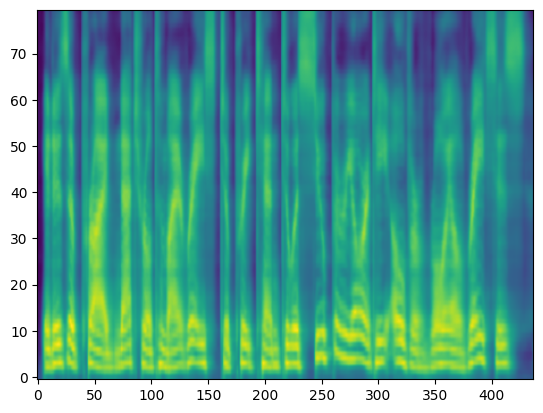

Real validation audio


SYNTHESIZED FOR -- Speaker: 9017 | Dataset size: 5 mins | Mixing:False | Text: ah if you had stayed in paris this would not have happened


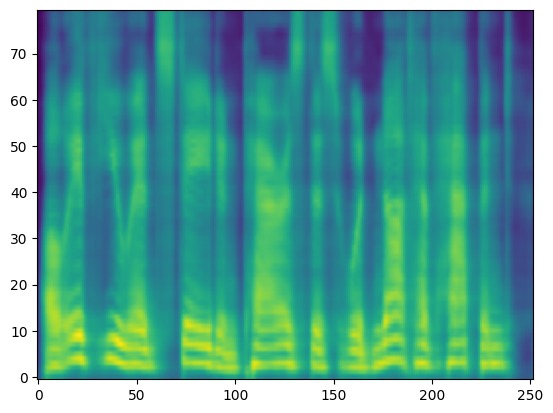

In [25]:
new_speaker_id = SPEAKER_ID
duration_mins = 5
mixing = False
original_speaker_id = "ljspeech"

for _, val_record in valid_df.iterrows():
    print("Real validation audio")
    ipd.display(ipd.Audio(val_record['audio_filepath'], rate=22050))
    print(f"SYNTHESIZED FOR -- Speaker: {new_speaker_id} | Dataset size: {duration_mins} mins | Mixing:{mixing} | Text: {val_record['text']}")
    spec, audio = generate_audio(val_record["text"], new_speaker_id)
    ipd.display(ipd.Audio(audio, rate=22050))
    %matplotlib inline
    imshow(spec, origin="lower", aspect="auto")
    plt.show()

### The same on a wandb.Table

In [26]:
table = wandb.Table(columns=['Text', 'Real validation audio', f'Audio Speaker {new_speaker_id}', 'Spec'])

sample_rate=22050

for _, val_record in valid_df.iterrows():
    speaker_spec, speaker_audio = generate_audio(val_record['text'], speaker_id=new_speaker_id)
    row = [val_record["text_no_preprocessing"],
           wandb.Audio(val_record['audio_filepath'], sample_rate=sample_rate), 
           wandb.Audio(speaker_audio.flatten(), sample_rate=sample_rate),
           wandb.Image(speaker_spec)]
    table.add_data(*row)

wandb.log({"table": table})

In [27]:
wandb.finish()